In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
house_file = pd.read_csv('../data/cleaned_complete.csv').drop(['Unnamed: 0','Unnamed: 0.1','index','dateUpdated','dateListed','geoLocation','geometry', 'index_right', 'SA2_maincode_2021','Population Increase','Earners (persons)','Median age of earners (years)','Male','Female',	'Person','Male Ratio','Female Ratio','Sum ($)','Mean ($)','Median ($)','propertyTypes','price'],axis = 1)

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
median_price = house_file.groupby(['bathrooms', 'bedrooms', 'carspaces','year','postcode'],as_index = False)['rent'].median('rent')
median_rent = dict()
for index, values in median_price.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    median_rent[key] = values['rent']
values_list = []
for item,values in house_file.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    hit = median_rent[key]
    values_list.append(hit)
house_file['median_rent'] = values_list 
house_file = house_file[house_file['rent'] <= 1.5 * house_file['median_rent']]
house_file

,bathrooms,bedrooms,carspaces,landAreaSqm,postcode,surburb,year,month,bond,rent,...,school,university,garden,park,playground,pitch,offence count,incidents recorded,Population,median_rent
0,1.0,1.0,0.0,NaN,3205,south melbourne,2019,1,NaN,360.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,790.0
1,2.0,2.0,1.0,NaN,3205,south melbourne,2019,1,NaN,725.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,565.0
2,1.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,500.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,570.0
3,1.0,3.0,0.0,NaN,3205,south melbourne,2019,1,NaN,795.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,580.0
4,2.0,2.0,0.0,NaN,3205,south melbourne,2019,1,NaN,825.0,...,1.0,0.0,8.0,16.0,10.0,5.0,22895.0,17201.0,12753.000000,580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,1.0,3.0,1.0,NaN,3701,dartmouth,2022,5,NaN,280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,302.0,230.0,6181.185987,500.0
100635,1.0,3.0,1.0,NaN,3701,dartmouth,2022,6,NaN,290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,302.0,230.0,6181.185987,500.0
100636,1.0,3.0,2.0,NaN,3700,tallangatta,2022,8,NaN,470.0,...,NaN,NaN,NaN,NaN,NaN,NaN,605.0,484.0,6181.185987,500.0
100637,1.0,3.0,2.0,NaN,3700,tallangatta,2021,3,NaN,310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,605.0,484.0,6153.000000,490.0


In [3]:
house_file.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'landAreaSqm', 'postcode',
       'surburb', 'year', 'month', 'bond', 'rent', 'longitude', 'latitude',
       'distance of the closest bus stop', 'count of bus stop',
       'distance of the closest train stop', 'count of train stop',
       'distance of the closest tram stop', 'count of tram stop',
       'distance of the closest vline stop', 'count of vline stop',
       'distance of the closest school', 'count of school',
       'count of hospital', 'distance to the closest shopping mall',
       'count of shopping mall', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'offence count',
       'incidents recorded', 'Population ', 'median_rent'],
      dtype='object')

In [4]:
postcode_count = pd.DataFrame(house_file['postcode'].value_counts()).reset_index().rename({"index":"postcode",'postcode':'count'},axis = 1)
postcode_count

,postcode,count
0,3000,8652
1,3008,4253
2,3006,3066
3,3029,2823
4,3141,2552
...,...,...
461,3890,1
462,3453,1
463,3221,1
464,3870,1


In [5]:
df = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode','year','month'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall']).drop(['landAreaSqm','longitude', 'latitude','median_rent','bond'],axis = 1)
df

,bathrooms,bedrooms,carspaces,postcode,year,month,rent,distance of the closest bus stop,count of bus stop,distance of the closest train stop,...,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,Population
0,0.0,1.0,0.0,3008,2019,12,850.0,0.456268,5.0,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25125.0,18185.0,16375.000000
1,0.0,1.0,0.0,3015,2019,10,250.0,0.370457,60.0,0.405244,...,14.0,19.0,0.0,10.0,67.0,26.0,40.0,10604.0,8777.0,19243.000000
2,0.0,1.0,0.0,3053,2022,5,175.0,0.449442,39.0,NaN,...,4.0,6.0,0.0,8.0,19.0,8.0,24.0,20238.0,15867.0,16701.220181
3,0.0,1.0,0.0,3079,2022,3,300.0,0.516233,48.0,0.526467,...,3.0,3.0,0.0,0.0,20.0,14.0,42.0,9248.0,7527.0,12678.988491
4,0.0,1.0,0.0,3171,2020,2,460.0,0.642444,64.0,0.670534,...,1.0,1.0,0.0,0.0,5.0,4.0,12.0,22113.0,16777.0,23636.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44166,4.0,5.0,4.0,3064,2021,11,540.0,0.386602,209.0,0.457571,...,11.0,24.0,1.0,77.0,119.0,48.0,190.0,55237.0,41689.0,22005.000000
44167,4.0,5.0,4.0,3133,2020,10,900.0,0.642555,64.0,NaN,...,1.0,1.0,0.0,0.0,4.0,0.0,2.0,7751.0,5998.0,11324.000000
44168,4.0,5.0,4.0,3335,2022,6,650.0,0.129284,10.0,NaN,...,1.0,4.0,0.0,140.0,48.0,30.0,56.0,4762.0,3843.0,25309.447163
44169,4.0,5.0,4.0,3844,2019,8,570.0,1.741227,124.0,NaN,...,0.0,0.0,0.0,0.0,4.0,3.0,3.0,42754.0,29717.0,16489.000000


In [6]:
house_file.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'landAreaSqm', 'postcode',
       'surburb', 'year', 'month', 'bond', 'rent', 'longitude', 'latitude',
       'distance of the closest bus stop', 'count of bus stop',
       'distance of the closest train stop', 'count of train stop',
       'distance of the closest tram stop', 'count of tram stop',
       'distance of the closest vline stop', 'count of vline stop',
       'distance of the closest school', 'count of school',
       'count of hospital', 'distance to the closest shopping mall',
       'count of shopping mall', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'offence count',
       'incidents recorded', 'Population ', 'median_rent'],
      dtype='object')

In [7]:
df2 = house_file.groupby(['bathrooms','bedrooms','carspaces','postcode'],as_index= False).mean(['rent','distance of the closest bus stop','distance of the closest train stop','distance of the closest tram stop','distance of the closest vline stop','distance of the closest school','distance to the closest shopping mall',]).drop(['landAreaSqm','longitude', 'latitude','median_rent','bond','year','month','Population '],axis = 1)
df2

,bathrooms,bedrooms,carspaces,postcode,rent,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,...,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded
0,0.0,1.0,0.0,3008,850.0,0.456268,5.0,NaN,0.0,0.433269,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25125.0,18185.0
1,0.0,1.0,0.0,3015,250.0,0.370457,60.0,0.405244,2.0,NaN,...,24.0,14.0,19.0,0.0,10.0,67.0,26.0,40.0,10604.0,8777.0
2,0.0,1.0,0.0,3053,175.0,0.449442,39.0,NaN,0.0,0.452666,...,13.0,4.0,6.0,0.0,8.0,19.0,8.0,24.0,20238.0,15867.0
3,0.0,1.0,0.0,3079,300.0,0.516233,48.0,0.526467,2.0,NaN,...,17.0,3.0,3.0,0.0,0.0,20.0,14.0,42.0,9248.0,7527.0
4,0.0,1.0,0.0,3171,460.0,0.642444,64.0,0.670534,2.0,NaN,...,0.0,1.0,1.0,0.0,0.0,5.0,4.0,12.0,22113.0,16777.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,4.0,5.0,4.0,3064,540.0,0.386602,209.0,0.457571,2.0,NaN,...,18.0,11.0,24.0,1.0,77.0,119.0,48.0,190.0,55237.0,41689.0
6863,4.0,5.0,4.0,3133,900.0,0.642555,64.0,NaN,0.0,0.645158,...,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,7751.0,5998.0
6864,4.0,5.0,4.0,3335,650.0,0.129284,10.0,NaN,0.0,NaN,...,11.0,1.0,4.0,0.0,140.0,48.0,30.0,56.0,4762.0,3843.0
6865,4.0,5.0,4.0,3844,570.0,1.741227,124.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,3.0,3.0,42754.0,29717.0


In [8]:
df_combined = df.merge(postcode_count,  on = 'postcode', how = 'left').fillna(0)
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,rent,distance of the closest bus stop,count of bus stop,distance of the closest train stop,...,school,university,garden,park,playground,pitch,offence count,incidents recorded,Population,count
0,0.0,1.0,0.0,3008,2019,12,850.0,0.456268,5.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,25125.0,18185.0,16375.000000,4253
1,0.0,1.0,0.0,3015,2019,10,250.0,0.370457,60.0,0.405244,...,19.0,0.0,10.0,67.0,26.0,40.0,10604.0,8777.0,19243.000000,295
2,0.0,1.0,0.0,3053,2022,5,175.0,0.449442,39.0,0.000000,...,6.0,0.0,8.0,19.0,8.0,24.0,20238.0,15867.0,16701.220181,1280
3,0.0,1.0,0.0,3079,2022,3,300.0,0.516233,48.0,0.526467,...,3.0,0.0,0.0,20.0,14.0,42.0,9248.0,7527.0,12678.988491,269
4,0.0,1.0,0.0,3171,2020,2,460.0,0.642444,64.0,0.670534,...,1.0,0.0,0.0,5.0,4.0,12.0,22113.0,16777.0,23636.000000,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44166,4.0,5.0,4.0,3064,2021,11,540.0,0.386602,209.0,0.457571,...,24.0,1.0,77.0,119.0,48.0,190.0,55237.0,41689.0,22005.000000,1482
44167,4.0,5.0,4.0,3133,2020,10,900.0,0.642555,64.0,0.000000,...,1.0,0.0,0.0,4.0,0.0,2.0,7751.0,5998.0,11324.000000,232
44168,4.0,5.0,4.0,3335,2022,6,650.0,0.129284,10.0,0.000000,...,4.0,0.0,140.0,48.0,30.0,56.0,4762.0,3843.0,25309.447163,237
44169,4.0,5.0,4.0,3844,2019,8,570.0,1.741227,124.0,0.000000,...,0.0,0.0,0.0,4.0,3.0,3.0,42754.0,29717.0,16489.000000,214


In [9]:
cpi_df = pd.read_csv('../data/cpi_df.csv')
df_combined = df_combined.merge(cpi_df, on = 'year')

In [10]:
xls = pd.ExcelFile('../data/gross-domestic-product.xlsx')
df1 = pd.read_excel(xls, 'Data')[36:].drop('Unnamed: 0', axis = 1).rename({'Unnamed: 1':'year','Unnamed: 2':'gdp'},axis = 1).reset_index().drop('index',axis = 1)
df1

,year,gdp
0,2019,54254.86
1,2020,52847.68
2,2021*,63529.29
3,2022*,67464.39
4,2023*,69717.12
5,2024*,72187.63
6,2025*,74353.74
7,2026*,76773.69
8,2027*,79345.79


In [11]:
gdp_list = list(df1['gdp'])
l = []
m = 0
for i in range(2019,2026):
    l.append([i,gdp_list[m]])
    m = m+1
gdp_df = pd.DataFrame(l, columns=['year','gdp'])
gdp_df

,year,gdp
0,2019,54254.86
1,2020,52847.68
2,2021,63529.29
3,2022,67464.39
4,2023,69717.12
5,2024,72187.63
6,2025,74353.74


In [12]:
df_combined = df_combined.merge(gdp_df, on = 'year')
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,rent,distance of the closest bus stop,count of bus stop,distance of the closest train stop,...,garden,park,playground,pitch,offence count,incidents recorded,Population,count,cpi,gdp
0,0.0,1.0,0.0,3008,2019,12,850.0,0.456268,5.0,0.000000,...,0.0,1.0,0.0,0.0,25125.0,18185.0,16375.0,4253,255.65,54254.86
1,0.0,1.0,0.0,3015,2019,10,250.0,0.370457,60.0,0.405244,...,10.0,67.0,26.0,40.0,10604.0,8777.0,19243.0,295,255.65,54254.86
2,0.0,1.0,1.0,3070,2019,1,320.0,0.456507,52.0,0.475671,...,2.0,14.0,14.0,51.0,18550.0,15386.0,16150.0,406,255.65,54254.86
3,0.0,1.0,1.0,3216,2019,1,200.0,0.471810,204.0,0.000000,...,1.0,52.0,36.0,48.0,29156.0,22993.0,14956.0,195,255.65,54254.86
4,0.0,2.0,0.0,3125,2019,2,190.0,0.575747,38.0,0.000000,...,0.0,0.0,0.0,0.0,8589.0,6487.0,13447.0,299,255.65,54254.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44166,4.0,5.0,2.0,3187,2021,2,900.0,0.516307,44.0,0.000000,...,0.0,16.0,12.0,52.0,6053.0,4527.0,16695.0,149,264.71,63529.29
44167,4.0,5.0,2.0,3551,2021,7,620.0,0.949961,115.0,0.000000,...,2.0,31.0,10.0,56.0,9938.0,7363.0,8306.0,110,264.71,63529.29
44168,4.0,5.0,3.0,3032,2021,4,700.0,0.363339,67.0,0.461734,...,1.0,92.0,44.0,72.0,30292.0,24502.0,12715.0,490,264.71,63529.29
44169,4.0,5.0,3.0,3116,2021,2,900.0,0.778759,20.0,0.000000,...,1.0,12.0,8.0,24.0,6407.0,4736.0,11873.0,60,264.71,63529.29


In [13]:
X = df_combined.drop('rent',axis=1)
y = df_combined['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [14]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'year', 'month',
       'distance of the closest bus stop', 'count of bus stop',
       'distance of the closest train stop', 'count of train stop',
       'distance of the closest tram stop', 'count of tram stop',
       'distance of the closest vline stop', 'count of vline stop',
       'distance of the closest school', 'count of school',
       'count of hospital', 'distance to the closest shopping mall',
       'count of shopping mall', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'offence count',
       'incidents recorded', 'Population ', 'count', 'cpi', 'gdp'],
      dtype='object')

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [16]:
regr = MLPRegressor(max_iter=500).fit(X_train_std, y_train)
regr.score(X_test_std, y_test)

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7846897701423149

In [56]:
rfc = RandomForestRegressor(n_estimators=100)  
rfc = rfc.fit(X_train_std, y_train)

print(f'model score on training data: {rfc.score(X_train_std, y_train)}')
print(f'model score on testing data: {rfc.score(X_test_std, y_test)}')

model score on training data: 0.9737676360817777
model score on testing data: 0.8026597156814962


In [58]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rfc, X_train_std, y_train, n_repeats=5, random_state=0)

In [61]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [62]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_combined.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

count of train stop0.659 +/- 0.006
bedrooms0.576 +/- 0.005
bathrooms0.343 +/- 0.002
postcode0.148 +/- 0.001
distance of the closest bus stop0.146 +/- 0.003
count of vline stop0.111 +/- 0.001
rent    0.091 +/- 0.001
carspaces0.078 +/- 0.001
pitch   0.054 +/- 0.001
incidents recorded0.040 +/- 0.000
month   0.039 +/- 0.001
count of bus stop0.031 +/- 0.000
Population 0.028 +/- 0.000
count of tram stop0.023 +/- 0.000
year    0.017 +/- 0.000
count   0.017 +/- 0.000
count of hospital0.016 +/- 0.000
distance of the closest vline stop0.016 +/- 0.000
offence count0.013 +/- 0.000
cpi     0.013 +/- 0.000
distance of the closest tram stop0.012 +/- 0.000
bench   0.008 +/- 0.000
kindergarten0.006 +/- 0.000
distance of the closest school0.006 +/- 0.000
distance of the closest train stop0.006 +/- 0.000
garden  0.005 +/- 0.000
count of school0.005 +/- 0.000
count of shopping mall0.005 +/- 0.000
parking 0.005 +/- 0.000
playground0.004 +/- 0.000
park    0.004 +/- 0.000
childcare0.003 +/- 0.000
university0

In [54]:
xgbc = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    seed = 27,
    max_depth = 4,
    verbosity = 1
)
xgbc.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_test, y_test)]
)
fea_imp = xgbc.feature_importances_
print(fea_imp)

[0]	validation_0-rmse:451.16408	validation_1-rmse:449.51844
[1]	validation_0-rmse:408.62346	validation_1-rmse:407.16017
[2]	validation_0-rmse:370.55692	validation_1-rmse:369.21869
[3]	validation_0-rmse:336.54107	validation_1-rmse:335.35634
[4]	validation_0-rmse:306.05893	validation_1-rmse:305.02409
[5]	validation_0-rmse:278.98422	validation_1-rmse:278.05377
[6]	validation_0-rmse:254.81269	validation_1-rmse:254.05187
[7]	validation_0-rmse:233.29271	validation_1-rmse:232.71894
[8]	validation_0-rmse:214.29978	validation_1-rmse:213.85676
[9]	validation_0-rmse:197.49746	validation_1-rmse:197.19860
[10]	validation_0-rmse:182.40578	validation_1-rmse:182.24350
[11]	validation_0-rmse:169.00788	validation_1-rmse:168.96221
[12]	validation_0-rmse:157.39307	validation_1-rmse:157.45125
[13]	validation_0-rmse:147.14640	validation_1-rmse:147.32803
[14]	validation_0-rmse:138.10249	validation_1-rmse:138.41197
[15]	validation_0-rmse:129.99253	validation_1-rmse:130.29407
[16]	validation_0-rmse:123.21618	v

In [55]:
xgbc.score(X_test_std, y_test)

-0.42983619230236303

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

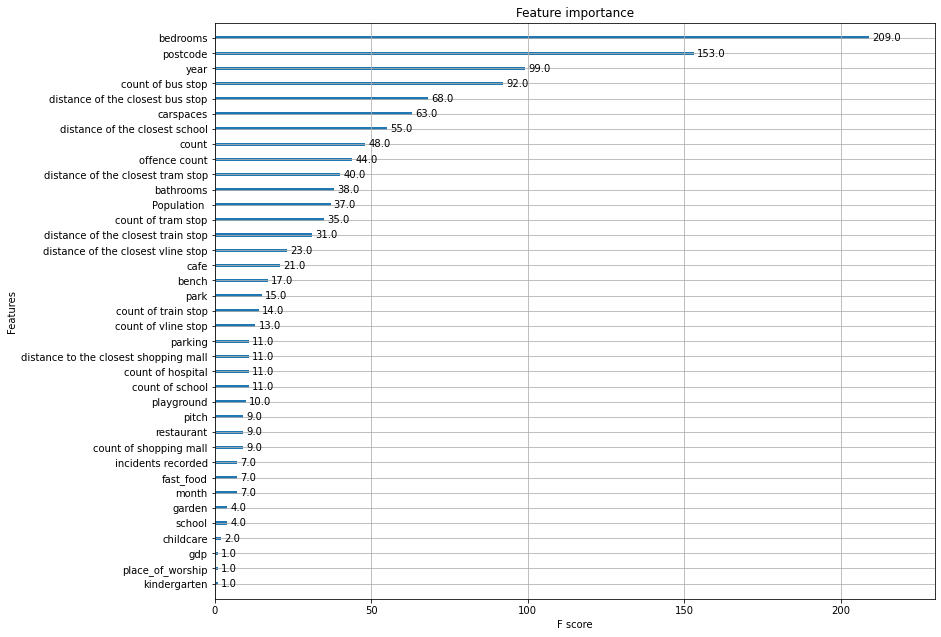

In [19]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
xgb.plot_importance(xgbc, ax)

In [81]:
df3 = pd.DataFrame()
for year in range(2023,2026):
    for month in range(1,13):
        tmp_df = df2.copy()
        year_list = [year]*len(df2)
        month_list = [month]*len(df2)
        tmp_df['year'] = year_list
        tmp_df['month'] = month_list
        df3= pd.concat([df3,tmp_df])
df3 = df3.reset_index().drop('index',axis = 1)
df3 = df3.drop('rent', axis = 1)

In [82]:
population = pd.read_csv('../data/population_forcasting.csv')
population_count = dict()
population['Postcode'] = population['Postcode'].fillna(value=0)
for index, value in population.iterrows():
    postcode = int(value['Postcode'])
    year = value['year']
    key = str(postcode)+ ' ' + str(year)
    population_count[key] = value['Total']

In [83]:
population_list = []
for index, value in df3.iterrows():
    postcode = int(value['postcode'])
    year = int(value['year'])
    key = str(postcode)+ ' ' + str(year)
    try: 
        count = population_count[key]
        population_list.append(count)
    except:
        population_list.append(None)
df3['population'] = population_list

In [84]:
cpi_df = pd.read_csv('../data/cpi_df.csv')
df3 = df3.merge(cpi_df, on = 'year', how='left')

In [85]:
import json
f = open("../data/year_school_address.txt")
data = json.load(f)
new_school = pd.DataFrame(data, columns=['year','link','address'])
new_school

,year,link,address
0,2024,http://www.schoolbuildings.vic.gov.au/aintree-...,40 Recreation Drive Aintree 3335
1,2024,http://www.schoolbuildings.vic.gov.au/aintree-...,42 Recreation Drive Aintree 3335
2,2024,http://www.schoolbuildings.vic.gov.au/alexande...,451 Hardys Rd Clyde North 3978
3,2024,http://www.schoolbuildings.vic.gov.au/black-fo...,10 Elementary Rd Mambourin 3024
4,2024,http://www.schoolbuildings.vic.gov.au/brookfie...,Brookfield 3338
...,...,...,...
70,2019,http://www.schoolbuildings.vic.gov.au/pakenham...,50 Atlantic Drive Pakenham 3810
71,2019,http://www.schoolbuildings.vic.gov.au/prahran-...,138 High Street Windsor 3181
72,2019,http://www.schoolbuildings.vic.gov.au/preston-...,Cooma St Preston 3072
73,2019,http://www.schoolbuildings.vic.gov.au/saltwate...,Saltwater Promenade Point Cook 3030


In [86]:
def get_postcode(add):
    add_list = add.split(' ')
    return add_list[-1]
new_school['postcode'] = new_school['address'].apply(get_postcode)
new_school

,year,link,address,postcode
0,2024,http://www.schoolbuildings.vic.gov.au/aintree-...,40 Recreation Drive Aintree 3335,3335
1,2024,http://www.schoolbuildings.vic.gov.au/aintree-...,42 Recreation Drive Aintree 3335,3335
2,2024,http://www.schoolbuildings.vic.gov.au/alexande...,451 Hardys Rd Clyde North 3978,3978
3,2024,http://www.schoolbuildings.vic.gov.au/black-fo...,10 Elementary Rd Mambourin 3024,3024
4,2024,http://www.schoolbuildings.vic.gov.au/brookfie...,Brookfield 3338,3338
...,...,...,...,...
70,2019,http://www.schoolbuildings.vic.gov.au/pakenham...,50 Atlantic Drive Pakenham 3810,3810
71,2019,http://www.schoolbuildings.vic.gov.au/prahran-...,138 High Street Windsor 3181,3181
72,2019,http://www.schoolbuildings.vic.gov.au/preston-...,Cooma St Preston 3072,3072
73,2019,http://www.schoolbuildings.vic.gov.au/saltwate...,Saltwater Promenade Point Cook 3030,3030


In [87]:
school_dict = {}
for index, value in new_school.iterrows():
    year = value['year']
    postcode = value['postcode']
    key = year + ' ' + postcode
    if key not in school_dict.keys():
        school_dict[key] = 1
    else:
        school_dict[key] += 1

In [88]:
for index, values in df3.iterrows():
    year = str(values['year'])
    postcode = str(values['postcode'])
    key = year + ' ' + postcode
    if key in school_dict.keys():
        school_values = values['school']
        print(school_values)
        df3.loc[index,'school'] = school_values + school_dict[key]


In [89]:
df3 = df3.merge(gdp_df, on = 'year', how='left')
df3 = df3.fillna(0)

In [90]:
df3 = df3.merge(postcode_count,  on = 'postcode', how = 'left')
df3

,bathrooms,bedrooms,carspaces,postcode,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,...,playground,pitch,offence count,incidents recorded,year,month,population,cpi,gdp,count
0,0.0,1.0,0.0,3008,0.456268,5.0,0.000000,0.0,0.433269,15.0,...,0.0,0.0,25125.0,18185.0,2023,1,0.0,277.84,69717.12,4253
1,0.0,1.0,0.0,3015,0.370457,60.0,0.405244,2.0,0.000000,0.0,...,26.0,40.0,10604.0,8777.0,2023,1,29726.0,277.84,69717.12,295
2,0.0,1.0,0.0,3053,0.449442,39.0,0.000000,0.0,0.452666,20.0,...,8.0,24.0,20238.0,15867.0,2023,1,0.0,277.84,69717.12,1280
3,0.0,1.0,0.0,3079,0.516233,48.0,0.526467,2.0,0.000000,0.0,...,14.0,42.0,9248.0,7527.0,2023,1,8946.0,277.84,69717.12,269
4,0.0,1.0,0.0,3171,0.642444,64.0,0.670534,2.0,0.000000,0.0,...,4.0,12.0,22113.0,16777.0,2023,1,9676.0,277.84,69717.12,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247207,4.0,5.0,4.0,3064,0.386602,209.0,0.457571,2.0,0.000000,0.0,...,48.0,190.0,55237.0,41689.0,2025,12,25571.0,291.50,74353.74,1482
247208,4.0,5.0,4.0,3133,0.642555,64.0,0.000000,0.0,0.645158,3.0,...,0.0,2.0,7751.0,5998.0,2025,12,15127.0,291.50,74353.74,232
247209,4.0,5.0,4.0,3335,0.129284,10.0,0.000000,0.0,0.000000,0.0,...,30.0,56.0,4762.0,3843.0,2025,12,17873.0,291.50,74353.74,237
247210,4.0,5.0,4.0,3844,1.741227,124.0,0.000000,0.0,0.000000,0.0,...,3.0,3.0,42754.0,29717.0,2025,12,8396.0,291.50,74353.74,214


In [91]:
predict_std = sc.transform(df3)
rent_list = rfc.predict(predict_std)

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- population
Feature names seen at fit time, yet now missing:
- Population 

  warnings.warn(message, FutureWarning)


In [92]:
df3['predicted_rent'] = rent_list
df3.to_csv('../data/curated/predicted_df.csv')

In [1]:
import pandas as pd
df3 = pd.read_csv('../data/curated/predicted_df.csv')

In [7]:
df3 = df3.drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)

In [8]:
suburb_postcode_df = pd.read_csv('../data/cleaned_complete.csv')[['postcode','surburb']]
df3_combinded = df3.merge(suburb_postcode_df, on = 'postcode', how = 'left')
df3_combinded.to_csv('../data/curated/predicted_df.csv')

: 

: 

In [1]:
suburb_mean_rent = df3_combinded.groupby(['month','year','surburb']).mean('predicted_rent')

NameError: name 'df3_combinded' is not defined